In [529]:
module Optimizers
using LinearAlgebra

export steepest_descent
function steepest_descent(x₀, A, b, tol)
    isposdef(A) || error("A must be Symmetric Positive Definite")
    x = x₀
    r = r₀ = b - A*x
    
    k = 1
    residuals = []
    
    while true
        if norm(r) / norm(r₀) < tol
            break
        end

        z = A*r
        α = (r'r)/(r'z)
        x = x + α*r
        r = r - α*z
        
        k += 1
        push!(residuals, norm(r))
    end
    
    return residuals, k, x
end

export steepest_descent_naive
function steepest_descent_naive(x₀, A, b, tol)
    isposdef(A) || error("A must be Symmetric Positive Definite")
    x = x₀
    r = r₀ = b - A*x
    
    k = 1
    residuals = []
    
    while true
        if norm(r) / norm(r₀) < tol
            break
        end

        α = (r'r)/(r'A*r)
        x = x + α*r
        r = b - A*x
        
        k += 1
        push!(residuals, norm(r))
    end
    
    return residuals, k, x
end

export conjugate_gradient_naive
function conjugate_gradient_naive(x₀, A, b, tol)
    isposdef(A) || error("A must be Symmetric Positive Definite")
    x = x₀
    r = r₀ = b - A*x
    d = r
    
    k = 1
    rs = []
    
    while true
         if norm(r / norm(r₀)) < tol
            break
        end
        
        α = (r'd)/(d'A*d)
        x = x + α*d
        r = b - A*x
        
        β = - (d'A*r)/(d'*A*d)
        d = r + β * d
        
        k += 1
        push!(rs, norm(r))
    end
    
    return rs, k, x
end

export conjugate_gradient
function conjugate_gradient(x₀, A, b, tol)
    isposdef(A) || error("A must be Symmetric Positive Definite")
    
    # TODO(Andrea): capire perche non funziona questo metodo
    
    x = x₀
    r = r₀ = b - A*x
    d = r
    
    k = 1
    rs = []
    
    while true
         if norm(r / norm(r₀)) < tol
            break
        end
        
        z = A*d
        
        α = (r'd)/(d'z)
        x = x + α*d
        
        r_old = copy(r)
        r = r_old - α*z
        
        β = - (r'z)/(r_old'z)
        d = r + β*d
        
        k += 1
        push!(rs, norm(r))
    end
    
    return rs, k, x
end
end

import Main.Optimizers

---

In [78]:
using LinearAlgebra, Plots, SparseArrays

In [530]:
n = Int(1e4)
α = 2.05

A = sparse(α*I, n, n)
A[diagind(A, -1)] = ones(n-1)
A[diagind(A, 1)] = ones(n-1)

b = A*ones(n)

x₀ = -0.5*ones(n);

---

# Tolerance vs Number of iterations

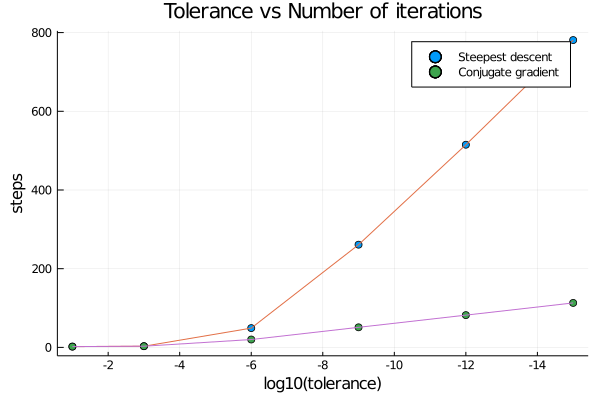

In [531]:
scatter(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Steepest descent"
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.steepest_descent(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
scatter!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label="Conjugate gradient"
)
plot!(
    [-1, -3, -6, -9, -12, -15],
    logtol -> Main.Optimizers.conjugate_gradient(x₀, A, b, 10^(logtol))[2],
    xflip=true,
    xlabel="log10(tolerance)", ylabel="steps", label=false
)
title!("Tolerance vs Number of iterations")

---

# Optimizations

In [532]:
using BenchmarkTools

In [533]:
@benchmark Main.Optimizers.steepest_descent_naive(x₀, $A, $b, 1e-8) setup=(x₀=randn(n))

BenchmarkTools.Trial: 
  memory estimate:  188.04 MiB
  allocs estimate:  5364
  --------------
  minimum time:     97.807 ms (7.60% GC)
  median time:      145.352 ms (7.18% GC)
  mean time:        219.402 ms (7.46% GC)
  maximum time:     643.395 ms (8.04% GC)
  --------------
  samples:          23
  evals/sample:     1

In [534]:
@benchmark Main.Optimizers.steepest_descent(x₀, $A, $b, 1e-8) setup=(x₀=randn(n))

BenchmarkTools.Trial: 
  memory estimate:  187.27 MiB
  allocs estimate:  5342
  --------------
  minimum time:     58.948 ms (14.04% GC)
  median time:      70.515 ms (14.64% GC)
  mean time:        78.349 ms (14.18% GC)
  maximum time:     163.666 ms (8.07% GC)
  --------------
  samples:          64
  evals/sample:     1

In [535]:
@benchmark Main.Optimizers.conjugate_gradient_naive(x₀, $A, $b, 1e-8) setup=(x₀=randn(n))

BenchmarkTools.Trial: 
  memory estimate:  56.36 MiB
  allocs estimate:  1500
  --------------
  minimum time:     34.202 ms (5.62% GC)
  median time:      37.222 ms (5.44% GC)
  mean time:        37.433 ms (7.21% GC)
  maximum time:     43.511 ms (4.36% GC)
  --------------
  samples:          134
  evals/sample:     1

In [536]:
@benchmark Main.Optimizers.conjugate_gradient(x₀, $A, $b, 1e-8) setup=(x₀=randn(n))

BenchmarkTools.Trial: 
  memory estimate:  51.09 MiB
  allocs estimate:  1362
  --------------
  minimum time:     11.912 ms (15.14% GC)
  median time:      14.855 ms (13.76% GC)
  mean time:        15.214 ms (16.38% GC)
  maximum time:     20.781 ms (19.36% GC)
  --------------
  samples:          328
  evals/sample:     1

---